# Setup

In [1]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.5f}'.format}, suppress = True)

from scipy.interpolate import RegularGridInterpolator

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

FILENAMES = ["magfields/bfield" + s + ".txt" for s in ["_corners", "100", "50", "20", "10", "5"]]

In [2]:
# For some reason this commands needs to be read twice to actually work
%matplotlib notebook

# File reading

In [3]:
def unpack_magfield_file(filename):
    B = [[], [], [], [], [], []]
    f = open(filename, "r")
    
    for line in f:
        mag_meas = line.replace("\n", "").split(' ')
        for i in range(len(mag_meas)):
            mag_meas[i] = float(mag_meas[i])
        if mag_meas[0] not in B[0]:
            B[0].append(mag_meas[0])
        if mag_meas[1] not in B[1]:
            B[1].append(mag_meas[1])
        if mag_meas[2] not in B[2]:
            B[2].append(mag_meas[2])
        B[3].append(mag_meas[3])
        B[4].append(mag_meas[4])
        B[5].append(mag_meas[5])

    f.close()
    
    return B

def pack_data(orig_arr, dest_size):
    dest_arr = []
    it       = 0
    for d in orig_arr:
        if it == 0:
            dest_arr.append([d])
        else:
            dest_arr[-1].append(d)
        it += 1
        if it == dest_size:
            it = 0
    return dest_arr

# Magnetic Field Estimation

In [5]:
def interpolators_from_data(data):
    return create_interpolators(data[0], data[1], data[2], data[3], data[4], data[5])

def create_interpolators(x, y, z, bx, by, bz):
    bx_z = pack_data(bx, len(z))
    by_z = pack_data(by, len(z))
    bz_z = pack_data(bz, len(z))

    bx_y = np.array(pack_data(bx_z, len(y)))
    by_y = np.array(pack_data(by_z, len(y)))
    bz_y = np.array(pack_data(bz_z, len(y)))

    bx_interpolator = RegularGridInterpolator((x, y, z), bx_y, method="linear", bounds_error=True)
    by_interpolator = RegularGridInterpolator((x, y, z), by_y, method="linear", bounds_error=True)
    bz_interpolator = RegularGridInterpolator((x, y, z), bz_y, method="linear", bounds_error=True)
    
    return (bx_interpolator, by_interpolator, bz_interpolator)

def get_b(l, B):
    return [B[0]([l[0], l[1], l[2]])[0], B[1]([l[0], l[1], l[2]])[0], B[2]([l[0], l[1], l[2]])[0]]

# Plotting

In [6]:
def plot_b(data):
    # Make the grid
    x, y, z = np.meshgrid(data[0], data[1], data[2])

    # Make the direction data for the arrows
    bx = np.array(pack_data(pack_data(data[3], len(data[2])), len(data[1])))
    by = np.array(pack_data(pack_data(data[4], len(data[2])), len(data[1])))
    bz = np.array(pack_data(pack_data(data[5], len(data[2])), len(data[1])))

    # Plot the data
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.quiver(x, y, z, bx, by, bz, length=100/len(data[0]), normalize=True, color="#2d3359")

    plt.show()

def compare_plots(data1, data2):
    # Make the grid
    x, y, z = np.meshgrid(data1[0], data1[1], data1[2])

    # Make the direction data for the arrows
    bx1 = np.array(pack_data(pack_data(data1[3], len(data1[2])), len(data1[1])))
    by1 = np.array(pack_data(pack_data(data1[4], len(data1[2])), len(data1[1])))
    bz1 = np.array(pack_data(pack_data(data1[5], len(data1[2])), len(data1[1])))
    
    bx2 = np.array(pack_data(pack_data(data2[3], len(data2[2])), len(data2[1])))
    by2 = np.array(pack_data(pack_data(data2[4], len(data2[2])), len(data2[1])))
    bz2 = np.array(pack_data(pack_data(data2[5], len(data2[2])), len(data2[1])))

    # Plot the data
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # NOTE: First quiver is red while second is blue
    ax.quiver(x, y, z, bx1, by1, bz1, length=100/len(data1[0]), normalize=True, color="#2d3359", alpha=0.7)
    ax.quiver(x, y, z, bx2, by2, bz2, length=100/len(data1[0]), normalize=True, color="#f26d3d", alpha=0.7)

    plt.show()

# Tests

In [7]:
FILENAME = FILENAMES[2]
real_data = unpack_magfield_file(FILENAME)

FileNotFoundError: [Errno 2] No such file or directory: 'magfields/bfield50.txt'

### Interpolator

In [7]:
B = interpolators_from_data(real_data)
print(get_b((42, 37, 302), B))

[0.09395401636799999, -0.33915985771199997, -0.16792961350399999]


### Plotter

<IPython.core.display.Javascript object>


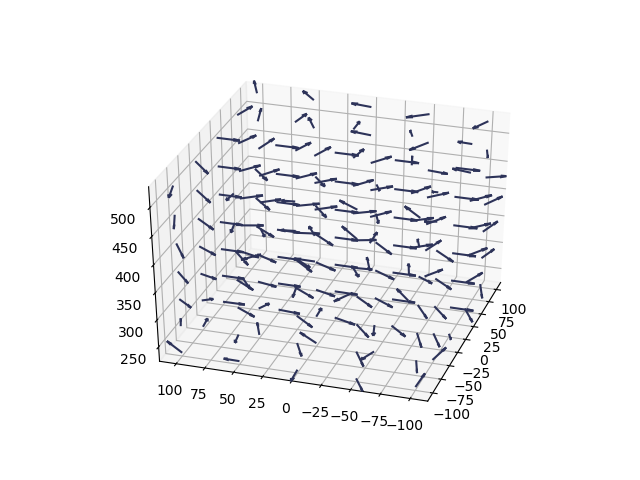

In [8]:
plot_b(real_data)

# Real Data vs Interpolated data

In [15]:
# data_l contains data from a larger sampling interval than data_s, e.g: 100 and 50.
def compare_data(data_l, data_s):
    B = interpolators_from_data(data_l)

    sim_bx = []
    sim_by = []
    sim_bz = []

    for xi in data_s[0]:
        for yi in data_s[1]:
            for zi in data_s[2]:
                (bxi, byi, bzi) = get_b([xi,yi,zi], B)
                sim_bx.append(bxi)
                sim_by.append(byi)
                sim_bz.append(bzi)

    # sim_data contains data with a sample interval equal to data_s, but the magnetic field interpolated from data_l
    sim_data = [data_s[0], data_s[1], data_s[2], sim_bx, sim_by, sim_bz]
    
    compare_plots(data_s, sim_data)

<IPython.core.display.Javascript object>


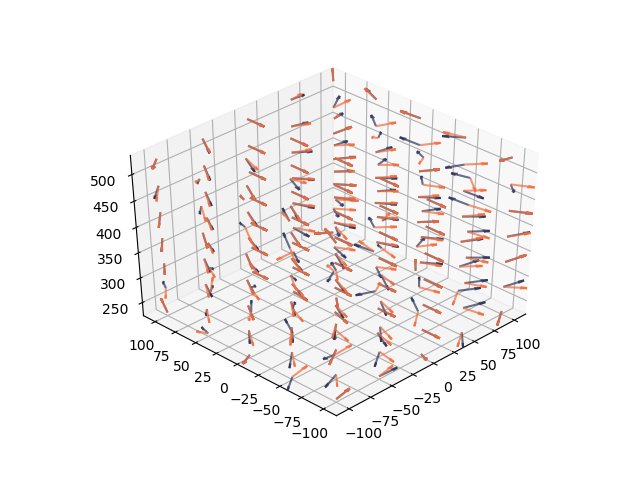

In [21]:
data_l = unpack_magfield_file(FILENAMES[1])
data_s = unpack_magfield_file(FILENAMES[2])

compare_data(data_l, data_s)